# New expectation value design PoC

[Qiskit Demoday Sep 16](https://github.com/qiskit-community/feedback/wiki/DemoDay#sep-16-2021)

Takashi Imamichi and Ikko Hamamura (IBM Research - Tokyo)

## Motivation

We propose a simple and generic interface for expectation values and their gradients.
The current workflow with opflow to get an expectation value is as follows.
```python
state = StateFn(...) # can be a circuit-based state or defined via a statevector or dictionary
operator = ... # some opflow operator, e.g. PauliSumOp
expectation = StateFn(operator, is_measurement=True) @ state
expectation_converter = PauliExpectation # method to evaluate the expected value, e.g. PauliExpectation, CVaRExpectation, AerPauliExpectation, ...
circuit_sampler = CircuitSampler(backend)
converted = expectation_converter.convert(expectation) 
sampled = circuit_sampler.convert(converted, parameters)
result = sampled.eval()
```

We propose a new design of the expectation value to make it generic and simple.
Essentially, we aim at the following workflow.

```python
operator = ... # some opflow operator, e.g. PauliSumOp
state = ... # a parametrized quantum circuit (or ansatz)
backend = ... # AerBackend or IBMQBackend
expval = PauliExpectationValue(state, operator, backend)
result = expval.evaluate(parameters).value
```

## Outline of the new design

We propose an abstract class for expectation value and gradient.
An instance will be initialized with the following objects:

- `state` $\psi(\theta)$: a (parametrized) quantum circuit or a state vector to be converted into a quantum circuit.
- `observable` $H$: we allow opflow `PauliSumOp` (primitive is `SparsePauliOp`) or quantum_info operator `BaseOperator` that is compatible with `SparsePauliOp` for simplicity.
- `backend`: Either `IBMQBackend` or `AerSimulator`. We don't support legacy simulator backends and BasicAer.
- (optional) `expval`: take an expectation value object as an input (e.g., gradient)

Users use `ExpectationValue.evaluate(parameters)` to obtain the expectation value.

Instances of our expectation value classes are immutable.
Users need to invoke the constructor to evaluate the expectation value of different states or observables.

The internal workflow consists of phases:

1. `ExpectationValue._preprocessing` generates quantum circuits corresponding to the pair of quantum state and observable. The circuits maybe left parametrized. This will be invoked on demand to avoid overhead of the constructor.
2. `ExpectationValue.evaluate(parameters)` transpiles quantum circuits (if necessary), puts parameter values to the transpiled circuits, and executes them on the backend.
3. `ExpectationValue._postprocessing` interprets the results of the backend into an expectation value and other information as `ExpectationValueResult`.

Note: we allow `ExpectationValue.evaluate(parameters)` to process a set of parameters and the output will be `ExpectationValueArrayResult`. See an example later.

`ExpectationValueGradient` may have the same interface and/or it may take `ExpectationValue` object as an input of the constructor.

## Demo

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np

observable
-1.052373245772859 * II
+ 0.39793742484318045 * IZ
- 0.39793742484318045 * ZI
- 0.01128010425623538 * ZZ
+ 0.18093119978423156 * XX

ansatz


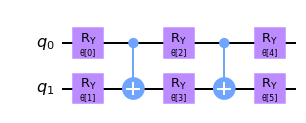

In [3]:
from qiskit.circuit.library import RealAmplitudes
from qiskit.opflow import PauliSumOp

observable = PauliSumOp.from_list(
    [
        ("II", -1.052373245772859),
        ("IZ", 0.39793742484318045),
        ("ZI", -0.39793742484318045),
        ("ZZ", -0.01128010425623538),
        ("XX", 0.18093119978423156),
    ]
)
print("observable")
print(observable)

ansatz = RealAmplitudes(num_qubits=2, reps=2)
print("\nansatz")
ansatz.decompose().draw("mpl")

## ExpectationValue class

In [4]:
from qiskit.evaluators import PauliExpectationValue

### PauliExpectationValue

Evaluate the expectation value by sampling. This supports both AerSimulator and IBMQ backends.

In [5]:
from qiskit.providers.aer import AerSimulator

backend = AerSimulator()

In [6]:
expval = PauliExpectationValue(ansatz, observable, backend=backend)
expval.evaluate([0, 1, 1, 2, 3, 5], shots=1000)

ExpectationValueResult(value=-1.3045851234732189, variance=0.2985086690184938, confidence_interval=(-1.3335981061414726, -1.2755721408049652))

In [7]:
# multi prameters
expval = PauliExpectationValue(ansatz, observable, backend=backend)
expval.evaluate([[0, 1, 1, 2, 3, 5], [1, 1, 2, 3, 5, 8]], shots=3000)

ExpectationValueArrayResult(values=array([-1.28753097, -1.32096817]), variances=array([0.30054645, 0.24197059]), confidence_intervals=array([[-1.30433766, -1.27072428],
       [-1.33568567, -1.30625067]]))

### Exact simulation by SaveExpectationValueVariance

In [8]:
from qiskit.evaluators import ExactExpectationValue

In [9]:
expval = ExactExpectationValue(ansatz, observable, backend=backend)
expval.evaluate([0, 1, 1, 2, 3, 5])

ExpectationValueResult(value=-1.2843665118617325, variance=0.26528532962023577, confidence_interval=None)

In [10]:
expval = ExactExpectationValue(ansatz, observable, backend=backend)
expval.evaluate(np.array([[0, 1, 1, 2, 3, 5], [1, 1, 2, 3, 5, 8]]))

ExpectationValueArrayResult(values=array([-1.28436651, -1.31875263]), variances=array([0.26528533, 0.42691205]), confidence_intervals=array([None, None], dtype=object))

### Transpiled Circuits

ExpectationValueResult(value=-1.2270449811062014, variance=0.3261140003605256, confidence_interval=(-1.2569617757694307, -1.1971281864429721))


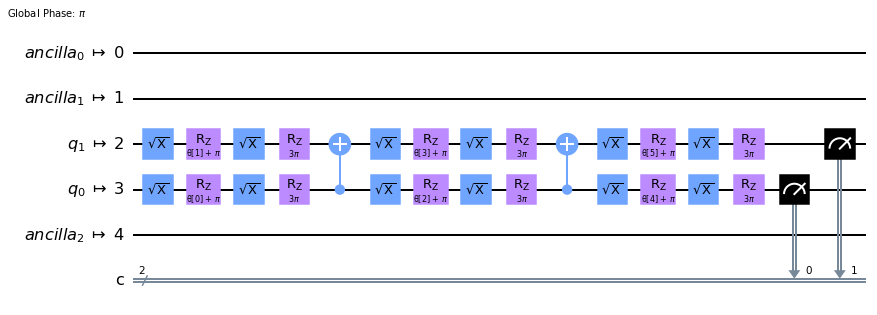

In [11]:
from qiskit.test.mock import FakeBogota

backend = AerSimulator.from_backend(FakeBogota())

expval = PauliExpectationValue(ansatz, observable, backend=backend)
expval.set_transpile_options(initial_layout=[3, 2])
print(expval.evaluate([0, 1, 1, 2, 3, 5]))
expval.transpiled_circuits[0].draw("mpl")

### Large number of shots

In [12]:
try:
    from qiskit import QuantumCircuit, QiskitError
    qc = QuantumCircuit(1, 1)
    qc.h(0)
    qc.measure(0, 0)
    from qiskit import IBMQ
    prov = IBMQ.load_account()
    ibmq_qasm_sim = prov.get_backend('ibmq_qasm_simulator')
    print(f"max_shots {backend.configuration().max_shots}")
    ibmq_qasm_sim.run(qc, shots=10000).result().get_counts()
except QiskitError as ex:
    print(ex.message)

max_shots 8192
Number of shots specified: 10000 exceeds max_shots property of the backend: 8192.


In [13]:
expval = PauliExpectationValue(ansatz, observable, backend=ibmq_qasm_sim)
expval.evaluate([0, 1, 1, 2, 3, 5], shots=10000)

ExpectationValueResult(value=-1.28629134229759, variance=0.3013702509749989, confidence_interval=(-1.2955064759928994, -1.2770762086022804))

### Readout error mitigation

In [14]:
from qiskit.evaluators.backends import ReadoutErrorMitigation

backend = AerSimulator.from_backend(FakeBogota())
mit_tensored = ReadoutErrorMitigation(
    backend, mitigation="tensored", refresh=600, shots=2000, mit_pattern=[[0], [1]]
)
mit_mthree = ReadoutErrorMitigation(
    backend, mitigation="mthree", refresh=600, shots=2000, qubits=[0, 1]
)
expval_raw = PauliExpectationValue(ansatz, observable, backend=backend)
expval_tensored = PauliExpectationValue(ansatz, observable, backend=mit_tensored)
expval_mthree = PauliExpectationValue(ansatz, observable, backend=mit_mthree)
shots = 4000
print(f"w/o mitigation shots={shots}, result={expval_raw.evaluate([0, 1, 1, 2, 3, 5], shots=shots)}")
print(f"w/ tensored mitigation shots={shots}, result={expval_tensored.evaluate([0, 1, 1, 2, 3, 5], shots=shots)}")
print(f"w/ M3 mitigation shots={shots}, result={expval_mthree.evaluate([0, 1, 1, 2, 3, 5], shots=shots)}")

w/o mitigation shots=4000, result=ExpectationValueResult(value=-1.2595981522160702, variance=0.3167834517853961, confidence_interval=(-1.2745298670322645, -1.244666437399876))
w/ tensored mitigation shots=4000, result=ExpectationValueResult(value=-1.2774601799810748, variance=0.3030202762495204, confidence_interval=(-1.292072288559631, -1.2628480714025185))
w/ M3 mitigation shots=4000, result=ExpectationValueResult(value=-1.274027046504209, variance=0.3045704741174017, confidence_interval=(-1.2886772367653694, -1.2593768562430485))


### Gradient of expectation value

In [15]:
from qiskit.evaluators.expectation_value.expectation_value_gradient import (
    FiniteDiffGradient,
    ParameterShiftGradient,
)

In [16]:
parameters = [0, 1, 1, 2, 3, 5]

exact_expval = ExactExpectationValue(ansatz, observable, backend=AerSimulator())
exact_findiff = FiniteDiffGradient(exact_expval, 1e-8)
print(f"fin diff of exact {exact_findiff.evaluate(parameters).values}")

exact_expval = ExactExpectationValue(ansatz, observable, backend=AerSimulator())
exact_findiff = ParameterShiftGradient(exact_expval)
print(f"param shift of exact {exact_findiff.evaluate([0, 1, 1, 2, 3, 5]).values}")

shots = 2000
findiff = FiniteDiffGradient(expval_raw, 1e-1)
paramshift = ParameterShiftGradient(expval_raw)
print(f"fin diff w/o mit {findiff.evaluate(parameters, shots=shots).values}")
print(f"param shift w/o mit {paramshift.evaluate(parameters, shots=shots).values}")

findiff = FiniteDiffGradient(expval_mthree, 1e-1)
paramshift = ParameterShiftGradient(expval_mthree)
print(f"fin diff w/  mit {findiff.evaluate([0, 1, 1, 2, 3, 5], shots=shots).values}")
print(f"param shift w/  mit {paramshift.evaluate(parameters, shots=shots).values}")

fin diff of exact [ 0.28213347  0.42656751  0.20442583  0.42656749 -0.17291453  0.0589814 ]
param shift of exact [ 0.28213349  0.42656754  0.20442588  0.42656754 -0.17291452  0.05898141]
fin diff w/o mit [ 0.16262713  0.4314544   0.34752583  0.24589932 -0.12426491  0.28484219]
param shift w/o mit [ 0.24911042  0.3794629   0.17450169  0.38138296 -0.14381146  0.05720959]
fin diff w/  mit [ 0.47428411  0.28015226  0.39108048  0.59261647 -0.07708405  0.07528248]
param shift w/  mit [ 0.27310091  0.40288055  0.20674927  0.41180033 -0.16378474  0.05274286]


### VQE by Scipy optimizer

In [17]:
from scipy.optimize import minimize

shots = 1000
expval = PauliExpectationValue(ansatz, observable, backend=AerSimulator(), append=True)
paramshift = ParameterShiftGradient(expval)
# this may take a long time...
result = minimize(
    lambda x: expval.evaluate(x, shots=shots, seed_simulator=123).value,
    np.zeros(6),
    jac=lambda x: paramshift.evaluate(x, shots=shots, seed_simulator=123).values,
)
print(result)

      fun: -1.847151931688854
 hess_inv: array([[ 1.81424069e+00, -7.89703086e-01, -5.73244156e-01,
        -2.21914037e-01,  5.87909808e-01,  4.22230305e-01],
       [-7.89703086e-01,  1.55393010e+00,  1.62068458e-01,
         6.68346234e-02, -6.46365845e-01, -6.41520197e-01],
       [-5.73244156e-01,  1.62068458e-01,  1.89981547e+00,
        -1.39292826e-03, -7.06428492e-01, -1.19853898e-01],
       [-2.21914037e-01,  6.68346234e-02, -1.39292826e-03,
         8.57102253e-01, -1.72732718e-01, -1.63459541e-01],
       [ 5.87909808e-01, -6.46365845e-01, -7.06428492e-01,
        -1.72732718e-01,  1.49153981e+00,  4.65053775e-01],
       [ 4.22230305e-01, -6.41520197e-01, -1.19853898e-01,
        -1.63459541e-01,  4.65053775e-01,  1.12790465e+00]])
      jac: array([-0.02623533,  0.01379811, -0.00251373,  0.02619514,  0.01860486,
       -0.01356285])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 69
      nit: 9
     njev: 57
   status: 2
  success: 

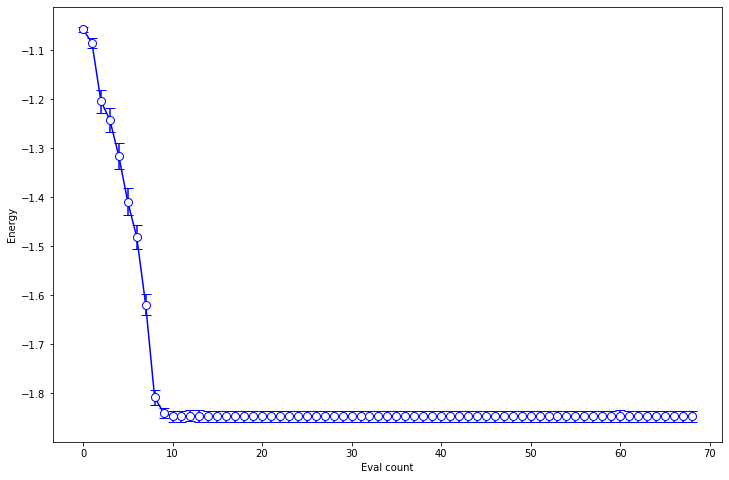

In [18]:
import matplotlib.pyplot as plt
from qiskit.evaluators.results import ExpectationValueResult

plt.figure(figsize=(12, 8))
y = [h.value for h in expval.history if isinstance(h, ExpectationValueResult)]
x = list(range(len(y)))
yerr = np.array(
    [tuple(abs(c - h.value) for c in h.confidence_interval) for h in expval.history if isinstance(h, ExpectationValueResult)]
).transpose()
plt.plot(y, color="blue")
plt.errorbar(x, y, yerr=yerr, capsize=5, fmt="o", markersize=8, ecolor="blue", markeredgecolor="blue", color="w")
plt.xlabel("Eval count")
plt.ylabel("Energy")
plt.show()

## Current status

The following classes and features have been implemented.

Expectation value classes
- `PauliExpectationValue`: expectation value for shot-based backends (both AerBackend and IBMQBackend) 
- `ExactExpectationValue`: exact expectation value with `SaveExpectationValueVariance` instruction supported only by Aer

Gradient of expectation value classes
- `FiniteDiffGradient`: finite difference gradient
- `ParameterShiftGradient`: parameter shift rule for the simple cases (parameters appears only once and they have coefficient 1)

Features
- Separate transpilation of ansatz and Pauli strings
  - A parameterized circuit corresponding to an ansatz is usually shared by Pauli strings that comprise the observable. This technique reduces the duplicate transpile of the shared part.
- Take a history of evaluations so that users can make a plot of optimization
  - Optimization algorithms e.g., [Scipy.optimize.minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html), should take care of the history. But, [OptimizeResult](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.OptimizeResult.html#scipy.optimize.OptimizeResult) is not enough to include variance and confidence interval of expectation values.
- Backend wrapper
  - Retry of job submission in case of cancel and/or network error
  - Split circuits if the size is larger than `max_experiments`
  - Copy circutis to realize users-set `shots` that is more than `max_shots`
  - Readout error mitigation (tensored, complete, M3)
    - Periodical calibration, e.g., calibration every 30 minutes

Questions
- Why does expval take care of backend as backend wrapper?
  - `QuantumInstance` of terra and `IBMQJobManager` (ManagedJob) of IBMQ provider can take care of only the split of circuits to satisfy `max_experiments`. But, as far as we know, there is no feature to realize `shots` more than `max_shots`. If this feature is implemented as part of IBMQ provider, it cannot be used for other backends, e.g., AQT and IonQ. Should it be part of terra?
  - We experimentally }implemented preemptive readout error mitigation calibration, i.e., we put the calibration job between a set of jobs generated by the split or copy of circuits

TODOs
- Finalize the interface of the design
- Make a PR of the first release of the expectation value

Ultimate goals (not necessarily inclueded as part of the first PR)
- Grouping algorithms of operators, AbelienGrouper (tensor product basis grouper) and grouper with entanglement measurements
- Better gradient support (maybe based on Opflow gradient)
- Qiskit Runtime support
- Gate error mitigation, e.g., zero noise extrapolation
- Classical shadow
- Entanglement forging
- On-chip parallelization
- Bootstrap (sampling from probability distribution obtained from backend)
- Merge shots (execute the same circuits again and merge the shots to realize a larger number of shots)